<a href="https://colab.research.google.com/github/Doutrespace/SoundscapeNET/blob/main/SoundscapeNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with YAMNet for Environmental Sound Classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is a pre-trained deep neural network developed by Google that can classify audio events into [521 different classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), including everyday sounds such as laughter, barking, or a siren. Originally trained on a large corpus of diverse audio data from YouTube, YAMNet is capable of robustly recognizing a wide array of sound events.

In this tutorial, you will learn how to:

1. **Load and use the YAMNet model for inference:** You'll start by loading the pre-trained YAMNet model and using it to predict the classes of sounds in audio clips.

2. **Build a new model using YAMNet embeddings:** We'll use YAMNet as a feature extractor to create embeddings from your audio data. These embeddings will serve as the input for a new model that you will build and train to classify specific sounds such as cat and dog sounds.

3. **Evaluate and export your model:** After training, you'll evaluate the performance of your new model on a test dataset and learn how to save and export the model for later use.

This hands-on approach will provide you with practical experience and a solid foundation in applying deep learning techniques for environmental sound classification using transfer learning.


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [1]:
#!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
#!pip install -q "tensorflow_io==0.28.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 17.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 3.19.6 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow-datasets 4.9.4 requires protobuf>=

In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## About YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, you will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. (This is similar to [transfer learning for image classification with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for more information.)

First, you will test the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the `load` function.

Note: to read the documentation of the model, use the model URL in your browser.

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

 Uploading data from my GoogleDrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# After mounting, you can access files like this:
audio_folder = '/content/drive/My Drive/SoundscapesWuerzburg'

# Assuming you have audio files in the specified directory, you can continue with your processing
import os

audio_files = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith('.wav')]
# Continue processing each file as needed


Mounted at /content/drive


You will need a function to load audio files, which will also be used later when working with the training data. (Learn more about reading audio files and their labels in [Simple audio recognition](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels).

Note: The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in the `[-1.0, 1.0]` range (for more information, go to [YAMNet's documentation on TF Hub](https://tfhub.dev/google/yamnet/1)).

In [6]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Utility functions for loading audio files and making sure the sample rate is correct.
@tf.function
def load_wav_16k_mono(filename):
    """Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio."""
    # Read the file
    file_contents = tf.io.read_file(filename)
    # Decode the WAV file
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    # Squeeze to remove channels dimension
    wav = tf.squeeze(wav, axis=-1)
    # Convert sample rate to int64 for compatibility with tfio
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [9]:
from google.colab import drive
drive.mount('/content/drive')

# After mounting, you can access files like this:
audio_folder = '/content/drive/My Drive/SoundscapesWuerzburg'

# Assuming you have audio files in the specified directory, you can continue with your processing
import os

audio_files = [os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith('.wav')]

# Continue processing each file as needed
# Example usage with a file named '20240130_063000.WAV' which should be defined earlier in your notebook
# or use files.upload() to upload a file and set 'testing_wav_file_name' to the uploaded file's path
testing_wav_file_name = os.path.join(audio_folder, '20240130_063000.WAV')  # Correctly construct the full path
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


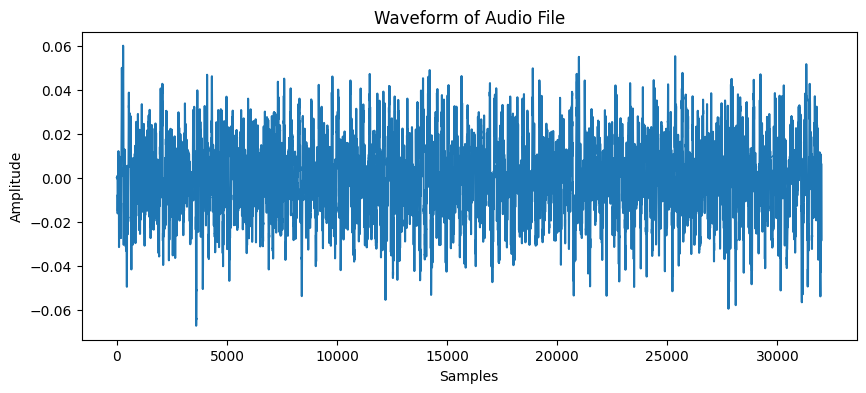

In [10]:
# Plotting the waveform
plt.figure(figsize=(10, 4))
plt.plot(testing_wav_data.numpy())
plt.title("Waveform of Audio File")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

# Play the audio file
display(Audio(testing_wav_data, rate=16000))

### Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at `yamnet_model.class_map_path()` in the CSV format.

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.

In [12]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Wind
The embeddings shape: (4, 1024)


## SONYC Urban Sound Tagging (SONYC-UST): a multilabel dataset from an urban acoustic sensor network

The provided audio has been acquired using the SONYC acoustic sensor network for urban noise pollution monitoring. Over 60 different sensors have been deployed in New York City, and these sensors have collectively gathered the equivalent of over 50 years of audio data, of which we provide a small subset. The data was sampled by selecting the nearest neighbors on VGGish features of recordings known to have classes of interest. All recordings are 10 seconds and were recorded with identical microphones at identical gain settings. To maintain privacy, we quantized the spatial information to the level of a city block, and we quantized the temporal information to the level of an hour. We also limited the occurrence of recordings with positive human voice annotations to one per hour per sensor.

In [17]:
# Define the path where you want to store the data
SONYC_UST_PATH = "/content/SONYC-UST"

# Create the directory structure
!mkdir -p $SONYC_UST_PATH/data

# Navigate to the directory
%cd $SONYC_UST_PATH/data

# Download the files
!wget https://zenodo.org/record/3693077/files/annotations.csv
!wget https://zenodo.org/record/3693077/files/audio.tar.gz
!wget https://zenodo.org/record/3693077/files/dcase-ust-taxonomy.yaml
!wget https://zenodo.org/record/3693077/files/README.md

# Extract the audio tar.gz file
!tar xf audio.tar.gz

# Remove the tar.gz file after extraction
!rm audio.tar.gz

# Return to the previous directory (or any specific directory)
%cd /content


/content/SONYC-UST/data
--2024-05-10 14:52:01--  https://zenodo.org/record/3693077/files/annotations.csv
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3693077/files/annotations.csv [following]
--2024-05-10 14:52:02--  https://zenodo.org/records/3693077/files/annotations.csv
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 17230769 (16M) [text/plain]
Saving to: ‘annotations.csv’

annotations.csv     100%[===================>]  16.43M  12.7MB/s    in 1.3s    

2024-05-10 14:52:03 (12.7 MB/s) - ‘annotations.csv’ saved [17230769/17230769]

--2024-05-10 14:52:03--  https://zenodo.org/record/3693077/files/audio.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|1

In [24]:
import os
import pandas as pd

# Corrected file paths
metadata_csv = '/content/SONYC-UST/data/annotations.csv'  # Assuming 'SONYC-UST' is directly under '/content'
base_audio_path = '/content/SONYC-UST/data/audio/'    # Update as necessary

# Check if the metadata file exists
if os.path.exists(metadata_csv):
    print("File exists. Loading data...")
    pd_data = pd.read_csv(metadata_csv)
    print(pd_data.head())  # Display the first few rows of the DataFrame to confirm correct loading
else:
    print("File does not exist. Check the file path.")

# Check the contents of the directory to ensure paths are correct
print("\nContents of the SONYC-UST directory:")
print(os.listdir('/content/SONYC-UST'))  # List contents to verify

print("\nContents of the audio directory:")
print(os.listdir('/content/SONYC-UST/data/audio'))  # List contents to verify


File exists. Loading data...
      split  sensor_id audio_filename  annotator_id  borough  block  \
0  validate          0  00_000066.wav            95        1    547   
1  validate          0  00_000066.wav           108        1    547   
2  validate          0  00_000066.wav           127        1    547   
3  validate          0  00_000071.wav            64        1    547   
4  validate          0  00_000071.wav            66        1    547   

    latitude  longitude  year  week  ...  \
0  40.729508 -73.993881  2017    28  ...   
1  40.729508 -73.993881  2017    28  ...   
2  40.729508 -73.993881  2017    28  ...   
3  40.729508 -73.993881  2016    50  ...   
4  40.729508 -73.993881  2016    50  ...   

   7-X_other-unknown-human-voice_proximity  8-1_dog-barking-whining_proximity  \
0                                      far                                far   
1                                       -1                                 -1   
2                                   

In [27]:
# Define the classes of interest by their presence columns
classes_of_interest = ['1_engine_presence', '2_machinery-impact_presence',
                       '3_non-machinery-impact_presence', '4_powered-saw_presence',
                       '5_alert-signal_presence', '6_music_presence',
                       '7_human-voice_presence', '8_dog_presence']



In [28]:
# Filter DataFrame to include rows where any specified class presence is 1
filtered_pd = pd_data[(pd_data[classes_of_interest] == 1).any(axis=1)]

# Map presence columns to new IDs if necessary
map_class_to_id = {name: idx for idx, name in enumerate(classes_of_interest, start=0)}

# Create a new target column based on the first matching class of interest
filtered_pd['target'] = (filtered_pd[classes_of_interest] == 1).idxmax(axis=1)
filtered_pd['target'] = filtered_pd['target'].apply(lambda name: map_class_to_id[name])

# Update the filename column to contain the full path to each audio file
filtered_pd['filename'] = filtered_pd['audio_filename'].apply(lambda x: os.path.join(base_audio_path, x))

# Display the first 10 rows of the filtered DataFrame
filtered_pd.head(10)

<ipython-input-28-4d3fda75c57a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd['target'] = (filtered_pd[classes_of_interest] == 1).idxmax(axis=1)
<ipython-input-28-4d3fda75c57a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pd['target'] = filtered_pd['target'].apply(lambda name: map_class_to_id[name])
<ipython-input-28-4d3fda75c57a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence,target,filename
0,validate,0,00_000066.wav,95,1,547,40.729508,-73.993881,2017,28,...,1,1,1,1,1,1,1,1,0,/content/SONYC-UST/data/audio/00_000066.wav
1,validate,0,00_000066.wav,108,1,547,40.729508,-73.993881,2017,28,...,1,0,0,0,0,0,0,0,0,/content/SONYC-UST/data/audio/00_000066.wav
2,validate,0,00_000066.wav,127,1,547,40.729508,-73.993881,2017,28,...,1,0,0,0,0,0,0,0,0,/content/SONYC-UST/data/audio/00_000066.wav
3,validate,0,00_000071.wav,64,1,547,40.729508,-73.993881,2016,50,...,1,0,0,0,0,0,0,0,0,/content/SONYC-UST/data/audio/00_000071.wav
4,validate,0,00_000071.wav,66,1,547,40.729508,-73.993881,2016,50,...,0,0,0,1,0,0,0,0,3,/content/SONYC-UST/data/audio/00_000071.wav
5,validate,0,00_000071.wav,133,1,547,40.729508,-73.993881,2016,50,...,0,1,0,0,0,0,0,0,1,/content/SONYC-UST/data/audio/00_000071.wav
7,validate,0,00_000085.wav,133,1,547,40.729508,-73.993881,2017,3,...,0,1,0,0,0,0,0,0,1,/content/SONYC-UST/data/audio/00_000085.wav
8,validate,0,00_000085.wav,152,1,547,40.729508,-73.993881,2017,3,...,1,0,0,1,0,0,0,0,0,/content/SONYC-UST/data/audio/00_000085.wav
9,validate,0,00_000118.wav,45,1,547,40.729508,-73.993881,2017,40,...,0,0,0,0,0,0,1,0,6,/content/SONYC-UST/data/audio/00_000118.wav
10,validate,0,00_000118.wav,58,1,547,40.729508,-73.993881,2017,40,...,1,0,0,0,0,0,1,0,0,/content/SONYC-UST/data/audio/00_000118.wav


In [37]:
# Print the column names of the DataFrame
print(filtered_pd.columns)

Index(['split', 'sensor_id', 'audio_filename', 'annotator_id', 'borough',
       'block', 'latitude', 'longitude', 'year', 'week', 'day', 'hour',
       '1-1_small-sounding-engine_presence',
       '1-2_medium-sounding-engine_presence',
       '1-3_large-sounding-engine_presence',
       '1-X_engine-of-uncertain-size_presence', '2-1_rock-drill_presence',
       '2-2_jackhammer_presence', '2-3_hoe-ram_presence',
       '2-4_pile-driver_presence',
       '2-X_other-unknown-impact-machinery_presence',
       '3-1_non-machinery-impact_presence', '4-1_chainsaw_presence',
       '4-2_small-medium-rotating-saw_presence',
       '4-3_large-rotating-saw_presence',
       '4-X_other-unknown-powered-saw_presence', '5-1_car-horn_presence',
       '5-2_car-alarm_presence', '5-3_siren_presence',
       '5-4_reverse-beeper_presence',
       '5-X_other-unknown-alert-signal_presence',
       '6-1_stationary-music_presence', '6-2_mobile-music_presence',
       '6-3_ice-cream-truck_presence',
       '6-X

### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the `fold` column to proper reflect these new rows.

The expanded `fold` column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [44]:
import tensorflow as tf

# Ensure 'filename' is treated as string
filenames = filtered_pd['filename'].astype(str).values
targets = filtered_pd['target'].values
splits = filtered_pd['split'].values

# Create the TensorFlow dataset
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, splits))

In [45]:
def load_wav_for_map(filename, label, split):
    """Load the WAV file, convert it to a tensor, and keep label and split."""
    # Convert filename to string to ensure compatibility with tf.io.read_file
    filename = tf.convert_to_tensor(filename, dtype=tf.string)
    wav_data = load_wav_16k_mono(filename)
    return wav_data, label, split

# Map the function to load WAV files to the dataset
main_ds = main_ds.map(load_wav_for_map)

In [46]:
def extract_embedding(wav_data, label, split):
    """Extract YAMNet embeddings from the WAV data, repeat labels and splits as needed."""
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return embeddings, tf.repeat(label, num_embeddings), tf.repeat(split, num_embeddings)

# Apply embedding extraction to the dataset and unbatch the results
main_ds = main_ds.map(extract_embedding).unbatch()

### Split the data

You will use the `split` column to split the dataset into train, validation and test sets.

SONYC is arranged into five uniformly-sized cross-validation `split`s, such that clips from the same original source are always in the same `split` - find out more in the  paper.

The last step is to remove the `split` column from the dataset since you're not going to use it during training.

In [47]:
import tensorflow as tf

# Cache the entire dataset to improve performance
cached_ds = main_ds.cache()

# Filter datasets based on the 'split' column value
train_ds = cached_ds.filter(lambda embedding, label, split: tf.equal(split, 'train'))
val_ds = cached_ds.filter(lambda embedding, label, split: tf.equal(split, 'validate'))
test_ds = cached_ds.filter(lambda embedding, label, split: tf.equal(split, 'test'))

# Remove the 'split' column from the datasets since it's no longer needed
remove_split_column = lambda embedding, label, split: (embedding, label)
train_ds = train_ds.map(remove_split_column)
val_ds = val_ds.map(remove_split_column)
test_ds = test_ds.map(remove_split_column)

# Final dataset preparation for training, validation, and testing
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)


## Create my model

In [48]:
import tensorflow as tf

# Define the number of classes you have
num_classes = 8  # Update this if the number of classes changes

# Create the model using the TensorFlow Keras API
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),  # Ensure the input shape matches the output shape of YAMNet embeddings
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)  # Output layer with a node for each class
], name='my_model')


In [49]:
# Display the model's architecture
my_model.summary()

# Compile the model with the specified loss function, optimizer, and metrics
my_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=['accuracy']
)


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 528,904
Trainable params: 528,904
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Set up early stopping to avoid overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

In [1]:
# Ensure you have a GPU enabled
import tensorflow as tf

# Check if GPU is available and identify the GPU type
gpu = tf.config.experimental.list_physical_devices('GPU')
if gpu:
    print('GPU is available:', tf.test.gpu_device_name(), '\nGPU details:', gpu)
else:
    print('GPU not available, consider changing the runtime type to GPU.')

import time

# Training the model
start_time = time.time()
history = my_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[callback]
)
end_time = time.time()

# Calculate and print the training time
total_training_time = end_time - start_time
print(f"Total training time for 20 epochs: {total_training_time / 60:.2f} minutes")


GPU is available: /device:GPU:0 
GPU details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


NameError: name 'my_model' is not defined

In [ ]:
# Evaluate the model on the test dataset to determine its final accuracy
loss, accuracy = my_model.evaluate(test_ds)
# Print out the loss and accuracy
print("Loss: ", loss)
print("Accuracy: ", accuracy)